In [1]:
import numpy as np
import ctypes
import pyautogui

from PIL import Image, ImageDraw
import decimal

from pytesseract import pytesseract
import pandas as pd
from tqdm import tqdm
import time
import mss
import mss.tools
from screeninfo import get_monitors

In [2]:
def get_screen():
    img = None
    with mss.mss() as sct:
        # Get information of monitor 2
        monitor_number = 2
        mon = sct.monitors[monitor_number]

        # The screen part to capture
        monitor = {
            "top": mon["top"],
            "left": mon["left"],
            "width": mon["width"],
            "height": mon["height"],
            "mon": monitor_number,
        }
        output = "sct-mon{mon}_{top}x{left}_{width}x{height}.png".format(**monitor)

        # Grab the data
        img = np.array(sct.grab(monitor))
        img = Image.fromarray(img)
        return img

def drange(x, y, jump):
    while x < y:
        yield float(x)
        x += decimal.Decimal(jump)
        
def cell_dims(x1, y1, x2, y2):
    return x1, y1, x2 - x1, y2 - y1

def cell_dims_from_list(list_onbj):
    return cell_dims(list_onbj[0], list_onbj[1], list_onbj[2], list_onbj[3])

def get_survey_scan_results_box():
    return [1282, 612, 1842, 770] #x,y Top Left ,x,y Bottom Right

def get_row_points():
    num_of_scanned_rows = 6
    space = (get_survey_scan_results_box()[3] - get_survey_scan_results_box()[1]) / num_of_scanned_rows
    row_points= list(drange(get_survey_scan_results_box()[1], get_survey_scan_results_box()[3], f'{space}'))
    final_row_points = list(np.rint(np.asarray(row_points)).astype(int))
    return final_row_points

def get_col_points():
    col_delta = get_survey_scan_results_box()[2] - get_survey_scan_results_box()[0]
    cols_points =  [col_delta * .05, col_delta * .45, col_delta * .15, col_delta * .18]
    temp_list = []
    for i in range(len(cols_points)):
        this_int = get_survey_scan_results_box()[0]
        for j in range(i + 1):
            this_int += cols_points[j]
        temp_list.append(this_int)

    final_col_points = np.array(temp_list)
    final_col_points = list(np.rint(final_col_points).astype(int))
    final_col_points = [get_survey_scan_results_box()[0]] + final_col_points + [get_survey_scan_results_box()[2]]
    return final_col_points

def get_cells(x_range, y_range):
    cells = {}
    for i, x in enumerate(x_range):
        for j, y in enumerate(y_range):
            try:
                cells[i, j] = tuple([x, y, x + x_range[i+1], y + y_range[j+1]])
            except:
                pass
    return cells

def render_outline(img, x_range, y_range):
    img_copy = img.copy()
    img = ImageDraw.Draw(img_copy)  

    # box
    img.line([get_survey_scan_results_box()[0], get_survey_scan_results_box()[1], get_survey_scan_results_box()[0], get_survey_scan_results_box()[3]], fill ="red", width = 5)
    img.line([get_survey_scan_results_box()[0], get_survey_scan_results_box()[3], get_survey_scan_results_box()[2], get_survey_scan_results_box()[3]], fill ="red", width = 5)
    img.line([get_survey_scan_results_box()[2], get_survey_scan_results_box()[3], get_survey_scan_results_box()[2], get_survey_scan_results_box()[1]], fill ="red", width = 5)
    img.line([get_survey_scan_results_box()[2], get_survey_scan_results_box()[1], get_survey_scan_results_box()[0], get_survey_scan_results_box()[1]], fill ="red", width = 5)
    # rows
    for i in y_range:
        img.line([get_survey_scan_results_box()[0], i, get_survey_scan_results_box()[2], i], fill="#ff6600", width=1)
    # cols
    for i in x_range:
        img.line([i, get_survey_scan_results_box()[1], i, get_survey_scan_results_box()[3]], fill="#ff6600", width=1)  
    return img_copy

def extract_values(img, cells, x_range, y_range):
    monitor_x_offset = 1920
    monitor_y_offset = -7
    frames = []
    columns = ['Locked', 'Ore', 'Quantity', 'Volume', 'Distance', 'click_target']
    for i in tqdm(range(len(y_range)-1)):
        frame = {}
        for j in range(0, len(x_range) - 1):
            cell = cell_dims_from_list(list(cells[j, i]))
            cell_image = img.crop(cell)

            transcript = pytesseract.image_to_string(cell_image, lang='eng')

            frame[columns[j]] = transcript.replace('\n','').replace('+','').replace('>','').replace('k m', ' km').replace(',','')
        frame['click_target'] = (cells[1, i][0] + 10 - monitor_x_offset, cells[1, i][1] + 10 - monitor_y_offset) # offset by 10x10 pixels
        frames.append(frame)
    df = pd.DataFrame(frames, columns=columns)
    return df

def convert_to_baw(img):
    thresh = 140
    fn = lambda x : 255 if x > thresh else 0
    img = img.convert('L').point(fn, mode='1')
    return img

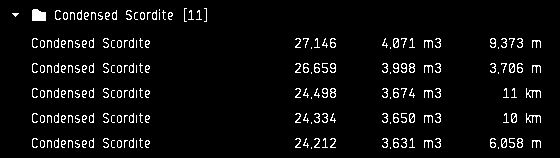

In [3]:
full_screen_image = get_screen()
convert_to_baw(full_screen_image.crop(get_survey_scan_results_box()))

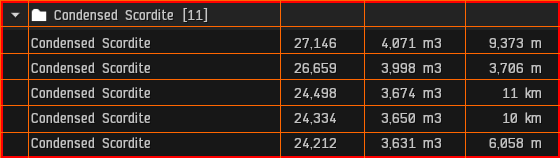

In [4]:
x_range = get_col_points()
y_range = get_row_points()

cells = get_cells(x_range, y_range)

img = render_outline(full_screen_image, x_range, y_range)
img.crop(get_survey_scan_results_box())

In [5]:
cells

{(0, 0): (1282, 612, 2592, 1250),
 (0, 1): (1282, 638, 2592, 1303),
 (0, 2): (1282, 665, 2592, 1356),
 (0, 3): (1282, 691, 2592, 1408),
 (0, 4): (1282, 717, 2592, 1461),
 (0, 5): (1282, 744, 2592, 1514),
 (1, 0): (1310, 612, 2872, 1250),
 (1, 1): (1310, 638, 2872, 1303),
 (1, 2): (1310, 665, 2872, 1356),
 (1, 3): (1310, 691, 2872, 1408),
 (1, 4): (1310, 717, 2872, 1461),
 (1, 5): (1310, 744, 2872, 1514),
 (2, 0): (1562, 612, 3208, 1250),
 (2, 1): (1562, 638, 3208, 1303),
 (2, 2): (1562, 665, 3208, 1356),
 (2, 3): (1562, 691, 3208, 1408),
 (2, 4): (1562, 717, 3208, 1461),
 (2, 5): (1562, 744, 3208, 1514),
 (3, 0): (1646, 612, 3393, 1250),
 (3, 1): (1646, 638, 3393, 1303),
 (3, 2): (1646, 665, 3393, 1356),
 (3, 3): (1646, 691, 3393, 1408),
 (3, 4): (1646, 717, 3393, 1461),
 (3, 5): (1646, 744, 3393, 1514),
 (4, 0): (1747, 612, 3589, 1250),
 (4, 1): (1747, 638, 3589, 1303),
 (4, 2): (1747, 665, 3589, 1356),
 (4, 3): (1747, 691, 3589, 1408),
 (4, 4): (1747, 717, 3589, 1461),
 (4, 5): (1747

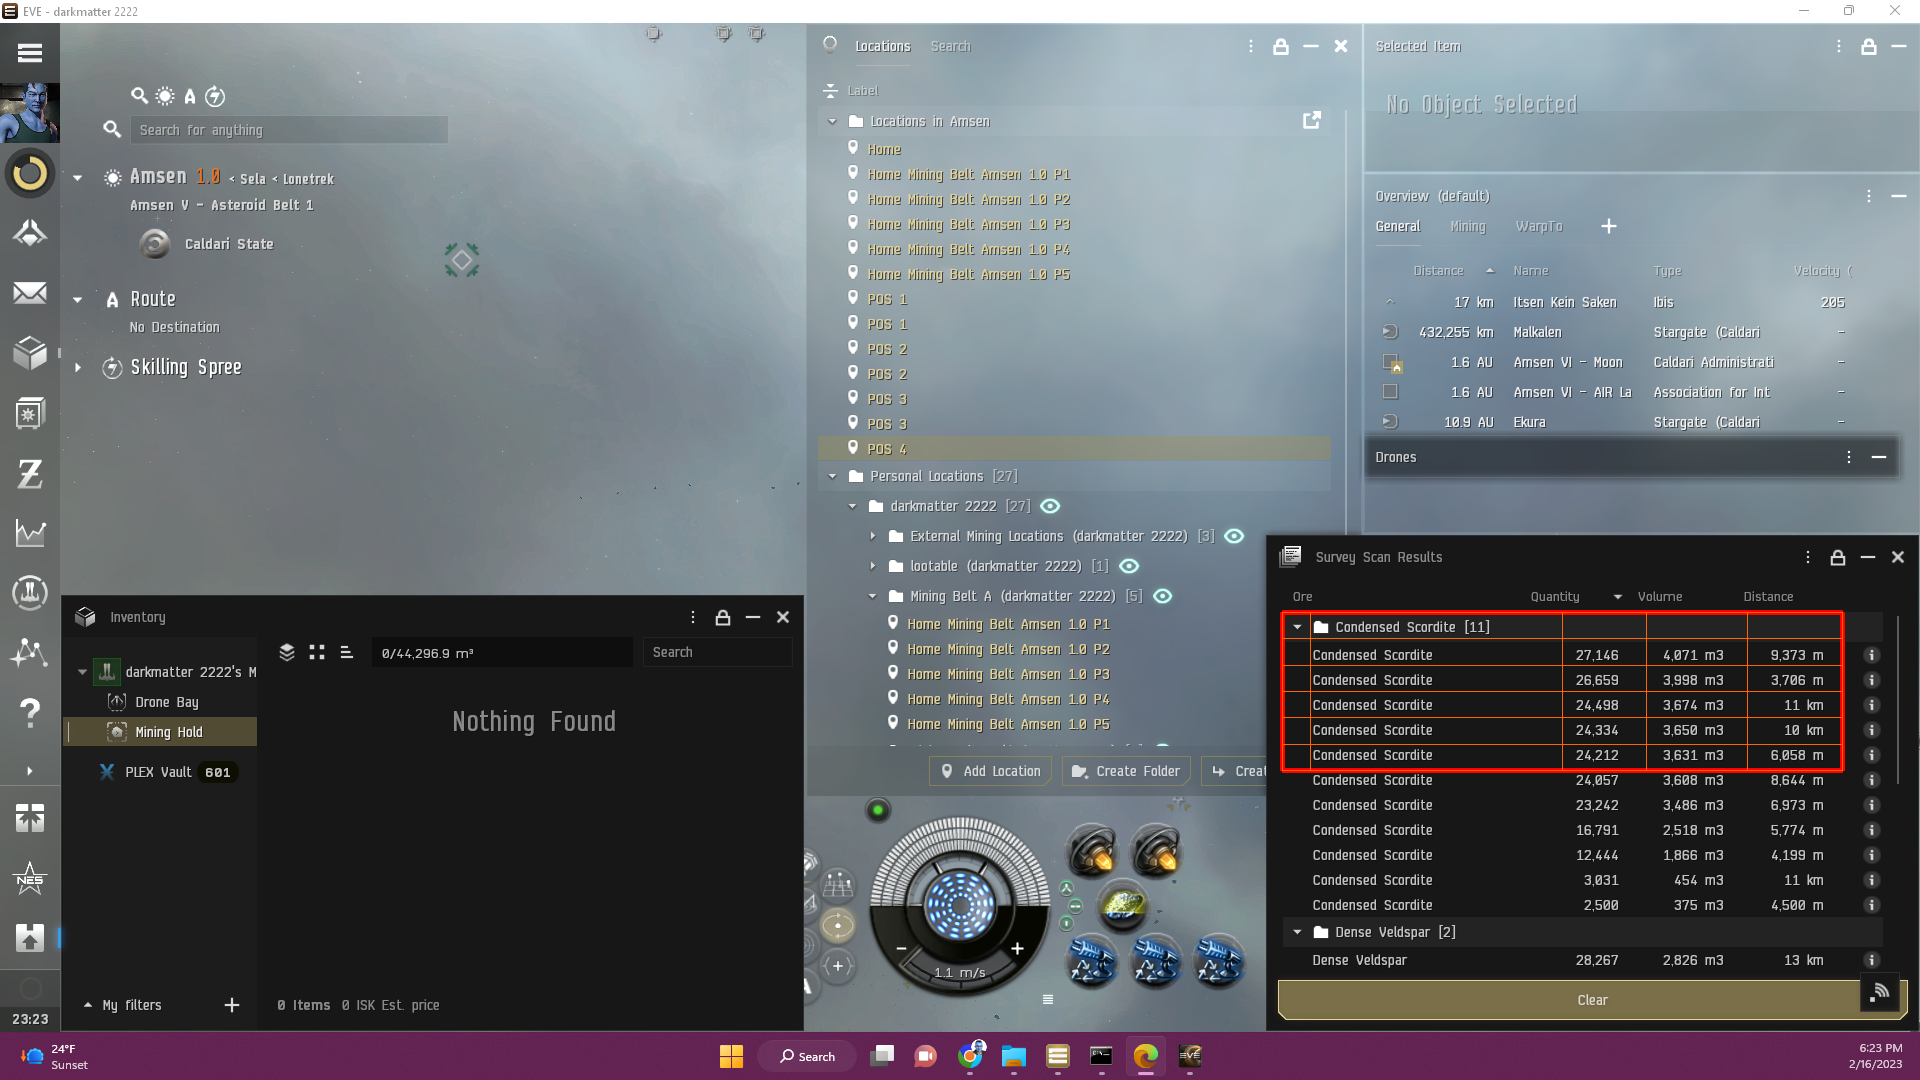

In [6]:
img

In [7]:
extract_values(img, cells, x_range, y_range)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.66it/s]


,Locked,Ore,Quantity,Volume,Distance,click_target
0,,Condensed Scordite [11],,,,"(-600, 629)"
1,,Condensed Scordite,27146,,373m,"(-600, 655)"
2,,Condensed Scordite,26653,,3786 m |,"(-600, 682)"
3,,Condensed Scordite,24498,,,"(-600, 708)"
4,,Condensed Scordite,24334,3650 m3,18 km,"(-600, 734)"
5,,Condensed Scardite,24.212,3631 m3,6858 m,"(-600, 761)"


In [8]:
def process():   
    img = get_screen()
    x_range = get_col_points()
    y_range = get_row_points()

    cells = get_cells(x_range, y_range)

    df = extract_values(img, cells, x_range, y_range)
    
    df.loc[df['Locked'] != '', 'Locked'] = '><'
    return df

# Models
https://github.com/tesseract-ocr/tessdata_best/blob/main/eng.traineddata  
C:\Program Files\Tesseract-OCR\tessdata

In [ ]:
time.sleep(0.5)

for l in range(100):
    print('checking...')
    df = process()
    snap_df = df[df['Quantity'].str.len()>0][0:2]
    snap_df = snap_df[~snap_df['Locked'].str.contains('><')]
    indicies = snap_df.index
    if len(indicies) == 2:
        print('starting 2x...')
        for i in indicies:
            pyautogui.moveTo(df.loc[i, 'click_target'])
            time.sleep(0.1)
            pyautogui.keyDown('ctrl')
            time.sleep(0.1)
            pyautogui.click()
            time.sleep(0.1)
            pyautogui.keyUp('ctrl')
            time.sleep(0.5)
        time.sleep(3)
        xy=None
        for i, index in enumerate(indicies):
            xy = df.loc[index, 'click_target']
            pyautogui.moveTo(xy)
            time.sleep(0.1)
            pyautogui.click()
            time.sleep(0.1)
            pyautogui.press(f'f{i + 1}')
            time.sleep(0.5)
        xy = (xy[0], xy[1]-200)
        pyautogui.moveTo(xy)
        print('started...')
        time.sleep(175)
    else:
        print('skipping...')
        time.sleep(10)

checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.71it/s]


starting 2x...
started...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.84it/s]


skipping...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.77it/s]


skipping...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.76it/s]


skipping...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.75it/s]


skipping...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.79it/s]


skipping...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.64it/s]


skipping...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.64it/s]


skipping...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.65it/s]


skipping...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.64it/s]


skipping...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.62it/s]


skipping...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.61it/s]


skipping...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.65it/s]


skipping...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.65it/s]


skipping...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.66it/s]


skipping...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.65it/s]


skipping...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.66it/s]


skipping...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.65it/s]


skipping...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.65it/s]


skipping...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.67it/s]


skipping...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.68it/s]


skipping...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.69it/s]


starting 2x...
started...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.69it/s]


skipping...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.70it/s]


skipping...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.66it/s]


skipping...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.69it/s]


skipping...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.69it/s]


skipping...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.68it/s]


skipping...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.69it/s]


skipping...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.67it/s]


skipping...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.69it/s]


skipping...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.68it/s]


skipping...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.69it/s]


skipping...
checking...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.70it/s]


starting 2x...
started...
